In [ ]:
!gdown --id 1GpATd_pM4mcnWWIs28-s1lgqdAg2Wdv-
!gdown --id 1pGd5tLwA30M7wkbJKdXHaae9tYVDICJ_

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1GpATd_pM4mcnWWIs28-s1lgqdAg2Wdv- 

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1pGd5tLwA30M7wkbJKdXHaae9tYVDICJ_ 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import all the libraries
#make sure that you import your libraries from tf.keras and not just keras
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,LSTM
import keras
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, concatenate, Flatten, Dropout
from keras.utils import np_utils 
from keras.datasets import mnist 
from keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import text_to_word_sequence, Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
import numpy as np 
import pandas as pd

In [ ]:
#read the csv file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/preprocessed_data.csv')
#print(df.shape)
print(df.describe)
print('*'*50)
print(df.count(axis= 0))
print('*'*50)
df.head(2)

<bound method NDFrame.describe of        school_state  ...   price
0                ca  ...  725.05
1                ut  ...  213.03
2                ca  ...  329.00
3                ga  ...  481.04
4                wa  ...   17.74
...             ...  ...     ...
109243           hi  ...  143.36
109244           nm  ...  268.57
109245           il  ...  399.00
109246           hi  ...  287.73
109247           ca  ...    5.50

[109248 rows x 9 columns]>
**************************************************
school_state                                    109248
teacher_prefix                                  109248
project_grade_category                          109248
teacher_number_of_previously_posted_projects    109248
project_is_approved                             109248
clean_categories                                109248
clean_subcategories                             109248
essay                                           109248
price                                           109

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [ ]:
# perform stratified train test split on the dataset
Y = df['project_is_approved']
X = df.drop('project_is_approved', axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify = Y, random_state = 42, test_size = 0.2)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify = y_train, random_state = 42, test_size = 0.2)
print(df.shape)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(109248, 9)
(69918, 8) (69918,) (21850, 8) (21850,)


## 1.1 Text Vectorization

In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())


In [ ]:
# Here we are doing padding in order to maintain the same shape
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
X_train_essays = X_train['essay'].values

tokenizer.fit_on_texts(X_train_essays)

train_sequences = tokenizer.texts_to_sequences(X_train_essays)
cv_sequences = tokenizer.texts_to_sequences(X_cv['essay'].values)
test_sequences = tokenizer.texts_to_sequences(X_test['essay'].values)


MAX_SEQUENCE_LENGTH = np.max([len(essay) for essay in train_sequences])

X_padded_essays_train = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_padded_essays_cv = pad_sequences(cv_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_padded_essays_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
#https://github.com/anirudhshenoy/LSTM-Assignment/blob/master/LSTM_assignment.ipynb

In [ ]:
# Using glove vectors to get the 300 dim representatrion
from tqdm import tqdm_notebook
GLOVE_VECTOR_DIMENSION = 300

word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index) + 1, GLOVE_VECTOR_DIMENSION))
for word, i in tqdm_notebook(word_index.items()):
    embedding_vector = model.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

    ## https://github.com/anirudhshenoy/LSTM-Assignment/blob/master/LSTM_assignment.ipynb

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/47379 [00:00<?, ?it/s]

## 1.2 Categorical feature Vectorization

In [ ]:
X_train_school_state = X_train['school_state'].values
state_vocab = list(set(state for state in X_train_school_state ))
vocab_size = len(state_vocab)

X_state_train = [one_hot(state, vocab_size) for state in X_train_school_state]
X_state_cv = [one_hot(state, vocab_size) for state in X_cv['school_state'].values]
X_state_test = [one_hot(state, vocab_size) for state in X_test['school_state'].values]


X_train_project_grade_category = X_train['project_grade_category'].values
grade_vocab = list(set(grade for grade in X_train_project_grade_category ))
vocab_size = len(grade_vocab)

X_grade_train = [one_hot(grade, vocab_size, filters = '') for grade in X_train_project_grade_category]
X_grade_cv = [one_hot(grade, vocab_size, filters = '') for grade in X_cv['project_grade_category'].values]
X_grade_test = [one_hot(grade, vocab_size, filters = '') for grade in X_test['project_grade_category'].values]


X_train_categories = X_train['clean_categories'].values
category_vocab = list(set(category for categories in X_train_categories for category in categories.split()))
vocab_size = len(category_vocab)

X_category_train = [one_hot(category, vocab_size, filters = '') for category in X_train_categories]
X_category_cv = [one_hot(category, vocab_size, filters = '') for category in X_cv['clean_categories'].values]
X_category_test = [one_hot(category, vocab_size, filters = '') for category in X_test['clean_categories'].values]


MAX_SEQUENCE_LENGTH_CATEGORY = np.max([len(essay) for essay in X_category_train])

X_category_train = pad_sequences(X_category_train, maxlen=MAX_SEQUENCE_LENGTH_CATEGORY)
X_category_cv = pad_sequences(X_category_cv, maxlen=MAX_SEQUENCE_LENGTH_CATEGORY)
X_category_test = pad_sequences(X_category_test, maxlen=MAX_SEQUENCE_LENGTH_CATEGORY)


X_train_sub_categories = X_train['clean_subcategories'].values
sub_category_vocab = list(set(category for categories in X_train_sub_categories for category in categories.split()))
vocab_size = len(sub_category_vocab)

X_sub_category_train = [one_hot(category, vocab_size, filters = '') for category in X_train_sub_categories]
X_sub_category_cv = [one_hot(category, vocab_size, filters = '') for category in X_cv['clean_subcategories'].values]
X_sub_category_test = [one_hot(category, vocab_size, filters = '') for category in X_test['clean_subcategories'].values]


MAX_SEQUENCE_LENGTH_SUB_CATEGORY = np.max([len(essay) for essay in X_sub_category_train])

X_sub_category_train = pad_sequences(X_sub_category_train, maxlen=MAX_SEQUENCE_LENGTH_SUB_CATEGORY)
X_sub_category_cv = pad_sequences(X_sub_category_cv, maxlen=MAX_SEQUENCE_LENGTH_SUB_CATEGORY)
X_sub_category_test = pad_sequences(X_sub_category_test, maxlen=MAX_SEQUENCE_LENGTH_SUB_CATEGORY)


X_train_teacher = X_train['teacher_prefix'].values
teacher_vocab = list(set(category for categories in X_train_teacher for category in categories.split()))
vocab_size = len(teacher_vocab)

X_teacher_train = [one_hot(prefix, vocab_size, filters = '') for prefix in X_train_teacher]
X_teacher_cv = [one_hot(prefix, vocab_size, filters = '') for prefix in X_cv['teacher_prefix'].values]
X_teacher_test = [one_hot(prefix, vocab_size, filters = '') for prefix in X_test['teacher_prefix'].values]

#https://github.com/anirudhshenoy/LSTM-Assignment/blob/master/LSTM_assignment.ipynb

## 1.3 Numerical feature Vectorization

In [ ]:
from sklearn import preprocessing
X_train_numeric = X_train[['teacher_number_of_previously_posted_projects', 'price']].values
# standardization of dependent variables
X_train_numeric = preprocessing.scale(X_train_numeric)
print(X_train_numeric)
X_cv_numeric = X_cv[['teacher_number_of_previously_posted_projects', 'price']].values
X_cv_numeric = preprocessing.scale(X_cv_numeric)
X_test_numeric = X_test[['teacher_number_of_previously_posted_projects', 'price']].values
X_test_numeric = preprocessing.scale(X_test_numeric)
X_test_numeric

[[-0.40445317  4.16454846]
 [ 0.10763013  1.46474502]
 [-0.22156627 -0.15061469]
 ...
 [-0.40445317  0.73026877]
 [ 2.88751089 -0.21731132]
 [-0.36787579 -0.78659141]]


array([[-0.39792632, -0.4507284 ],
       [-0.39792632, -0.41932425],
       [-0.39792632, -0.68134273],
       ...,
       [-0.22273823,  0.11021108],
       [-0.32785108,  0.55991431],
       [-0.29281346, -0.28075475]])

## 1.4 Defining the model

<img src='https://i.imgur.com/w395Yk9.png'>

In [ ]:
# ESSAYS LAYER
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

input_essays = Input(shape=(MAX_SEQUENCE_LENGTH,))
x_essays = Embedding(len(word_index) + 1, 
              GLOVE_VECTOR_DIMENSION, 
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable = False)(input_essays)
x_essays1 = LSTM(10)(x_essays)
lstm_essay_model = Model(input_essays, x_essays1)


EMBEDDING_DIMENSION = 50

# STATES LAYER
input_states = Input(shape=(1,))
x_state = Embedding(len(state_vocab) + 1, EMBEDDING_DIMENSION, input_length=1)(input_states)
x_state = Flatten()(x_state)
state_model = Model(input_states, x_state)

# GRADE LAYER
input_grades = Input(shape=(1,))
x_grade = Embedding(len(grade_vocab) + 1, EMBEDDING_DIMENSION, input_length=1)(input_grades)
x_grade = Flatten()(x_grade)
grade_model = Model(input_grades, x_grade)

# CATEGORY LAYER
input_category = Input(shape=(MAX_SEQUENCE_LENGTH_CATEGORY,))
x_category = Embedding(len(category_vocab) + 1, EMBEDDING_DIMENSION, input_length=MAX_SEQUENCE_LENGTH_CATEGORY)(input_category)
x_category = Flatten()(x_category)
category_model = Model(input_category, x_category)

# SUB CATEGORY LAYER
input_sub_category = Input(shape=(MAX_SEQUENCE_LENGTH_SUB_CATEGORY,))
x_sub_category = Embedding(len(sub_category_vocab) + 1, EMBEDDING_DIMENSION, input_length=MAX_SEQUENCE_LENGTH_SUB_CATEGORY)(input_sub_category)
x_sub_category = Flatten()(x_sub_category)
sub_category_model = Model(input_sub_category, x_sub_category)

# TEACHER PREFIX LAYER
input_teacher = Input(shape=(1,))
x_teacher = Embedding(len(teacher_vocab) + 1, EMBEDDING_DIMENSION, input_length=1)(input_teacher)
x_teacher = Flatten()(x_teacher)
teacher_model = Model(input_teacher, x_teacher)

# NUMERIC LAYER
input_teacher = Input(shape=(2,))
x_numeric = Dense(16, activation='relu')(input_teacher)
numeric_model = Model(input_teacher, x_numeric)


combined = concatenate([lstm_essay_model.output, 
                        state_model.output,
                        grade_model.output,
                        category_model.output,
                        sub_category_model.output,
                        teacher_model.output,
                        numeric_model.output
                       ])


x_combined = Dense(128, activation='relu')(combined)
x_combined = Dropout(0.5)(x_combined)

x_combined = Dense(128, activation='relu')(combined)
x_combined = Dropout(0.5)(x_combined)

x_combined = Dense(128, activation='relu')(combined)
x_combined = Dense(1, activation="sigmoid")(x_combined)

final_model = Model(inputs=[lstm_essay_model.input, 
                            state_model.input,
                            grade_model.input,
                            category_model.input,
                            sub_category_model.input,
                            teacher_model.input,
                            numeric_model.input], 
                    outputs = x_combined)

## https://github.com/anirudhshenoy/LSTM-Assignment/blob/master/LSTM_assignment.ipynb

In [ ]:
from keras import backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.callbacks import Callback, EarlyStopping
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier


# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
'''
def auc_roc(y_true, x_test):
  y_pred = model.predict(x_test)
  auc = roc_auc_score(y_test, y_pred)

  return auc


    # any tensorflow metric
    value, update_op = tf.metrics.auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value


y_pred = model.predict_proba(x_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(auc)
'''
## https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras/46844409#46844409

"\ndef auc_roc(y_true, x_test):\n  y_pred = model.predict(x_test)\n  auc = roc_auc_score(y_test, y_pred)\n\n  return auc\n\n\n    # any tensorflow metric\n    value, update_op = tf.metrics.auc(y_pred, y_true)\n\n    # find all variables created for this metric\n    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]\n\n    # Add metric variables to GLOBAL_VARIABLES collection.\n    # They will be initialized for new session.\n    for v in metric_vars:\n        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)\n\n    # force to update metric values\n    with tf.control_dependencies([update_op]):\n        value = tf.identity(value)\n        return value\n\n\ny_pred = model.predict_proba(x_test)[:,1]\nauc = roc_auc_score(y_test, y_pred)\nprint(auc)\n"

In [ ]:
#This is for tensorboard callbacks
from keras.callbacks import TensorBoard
import datetime
filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"               
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True,mode='auto')                                  
                                                                   
#earlystop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)    

#optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) 

#log_dir = "logs/fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
#tensorboard_callbacks = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1, write_graph = True,write_grads = True)
#callbacks_list = [checkpoint, earlystop] 

## 1.5 Compiling and fititng your model

In [ ]:
final_model.compile(loss = 'binary_crossentropy', metrics = ['accuracy',get_f1,'AUC'], optimizer = 'adam')
final_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 320)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 3)]          0           []                               
                                                                                            

In [ ]:
test_input_length = 69918

input_train = [  np.array(X_padded_essays_train)[:test_input_length], 
                 np.array(X_state_train)[:test_input_length],
                 np.array(X_grade_train)[:test_input_length],
                 np.array(X_category_train)[:test_input_length],
                 np.array(X_sub_category_train)[:test_input_length],
                 np.array(X_teacher_train)[:test_input_length],
                 np.array(X_train_numeric)[:test_input_length],
                ]


input_cv = [  np.array(X_padded_essays_cv)[:test_input_length], 
                 np.array(X_state_cv)[:test_input_length],
                 np.array(X_grade_cv)[:test_input_length],
                 np.array(X_category_cv)[:test_input_length],
                 np.array(X_sub_category_cv)[:test_input_length],
                 np.array(X_teacher_cv)[:test_input_length],
                 np.array(X_cv_numeric)[:test_input_length],
                ]

In [ ]:
final_model.fit(input_train, y_train,epochs =10, validation_data=[input_cv, y_cv],batch_size = 128, verbose = 1)
         

Epoch 1/10
547/547 [==============================] - 16s 23ms/step - loss: 0.4077 - accuracy: 0.8470 - get_f1: 0.9158 - auc: 0.6516 - val_loss: 0.3808 - val_accuracy: 0.8506 - val_get_f1: 0.9186 - val_auc: 0.7213
Epoch 2/10
547/547 [==============================] - 12s 22ms/step - loss: 0.3765 - accuracy: 0.8511 - get_f1: 0.9184 - auc: 0.7313 - val_loss: 0.3715 - val_accuracy: 0.8542 - val_get_f1: 0.9188 - val_auc: 0.7412
Epoch 3/10
547/547 [==============================] - 12s 22ms/step - loss: 0.3685 - accuracy: 0.8538 - get_f1: 0.9191 - auc: 0.7483 - val_loss: 0.3714 - val_accuracy: 0.8527 - val_get_f1: 0.9171 - val_auc: 0.7485
Epoch 4/10
547/547 [==============================] - 12s 22ms/step - loss: 0.3630 - accuracy: 0.8547 - get_f1: 0.9193 - auc: 0.7589 - val_loss: 0.3662 - val_accuracy: 0.8545 - val_get_f1: 0.9192 - val_auc: 0.7502
Epoch 5/10
547/547 [==============================] - 12s 22ms/step - loss: 0.3585 - accuracy: 0.8570 - get_f1: 0.9205 - auc: 0.7686 - val_loss:

<built-in method keys of dict object at 0x7f9055a1c0f0>


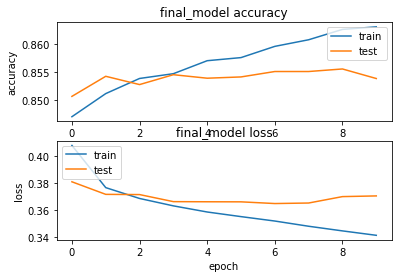

In [ ]:
#list all data in history
print(final_model.history.history.keys)

import matplotlib.pyplot as plt 

# summarize history for accuracy
plt.subplot(211)
plt.plot(final_model.history.history['accuracy'])
plt.plot(final_model.history.history['val_accuracy'])
plt.title('final_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
#plt.show()

# summarize history for loss
plt.subplot(212)
plt.plot(final_model.history.history['loss'])
plt.plot(final_model.history.history['val_loss'])
plt.title('final_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#https://stackoverflow.com/questions/51731207/python-neural-network-typeerror-history-object-is-not-subscriptable
#https://machinelearningmastery.com/display-deep-learning-final_model-training-history-in-keras/
#https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-final_models/

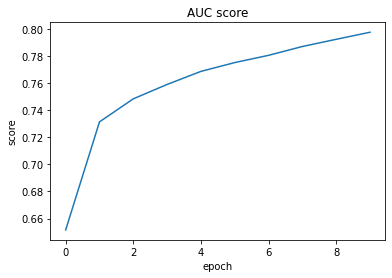

In [ ]:
# AUC plot
plt.plot(final_model.history.history['auc'])
plt.title('AUC score')
plt.ylabel('score')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [1]:
# Please compare all your models using Prettytable library
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "AUC"]
x.add_row(['Model 1',0.7492])
print(x)

+---------+--------+
|  Model  |  AUC   |
+---------+--------+
| Model 1 | 0.7492 |
+---------+--------+
